## Lasso Model

### Section 1: Business understanding

In this data science project, we aim to build a model that can predict the prices of Airbnb listings based on various features. By doing so, we hope to provide property owners and investors with valuable insights that can inform their pricing strategies and help them make informed decisions about their Airbnb listings.

**Specifically, we aim to answer the folowing questions:**
1. Which appartment's features will give the host the opportunity to -easily- to charge more?
2. What are the most desired areas of Seattle, for Airbnb guests?
3. What are some key recommendations for the host?

To achieve this goal we were given 3 databases:

**Listings**: including full descriptions and average review score.

**Reviews**: including unique id for each reviewer and detailed comments.

**Calendar**: including listing id and the price and availability for that day.

It has been greatly documented that reviews are one of the most relevant features when a customer is deciding their willingness to pay for any kind of good. Nonetheless, this study will focus on other type of features. Given this context we won't focus of NPL models, but on regression ones. Specifically, a Lasso model will allow us to observe very clearly what is the impact of different features on Airbnb's price, disregarding the features that are irrelevant.

### Section 2: Data understanding

Import libraries

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import zipfile
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

### Gather

In [26]:
def unzip_efficient(file_names,folder,path):
    '''
    returns upziped files
    input:
            file_names: names of csv files
            folder: name of zip file
            path: path to the folder
    output:
            uziped files in folder
    '''
    for file_name in file_names:
        with zipfile.ZipFile(path+folder, 'r') as zip:
            zip.extract(file_name, path)

In [27]:
file_names = ['calendar.csv', 'listings.csv', 'reviews.csv']
folder = 'archive.zip'
path = 'C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/'
unzip_efficient(file_names,folder,path)

Load databases

In [28]:
os.chdir('C:/Users/MIGOMLOZ/Desktop/DS_Nanodegree/')  
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews =  pd.read_csv('reviews.csv')

### Assess

To address our 3 questions, we must focus on the columns that might be helpful. The following is a first-approach selection:

In [29]:
col = 'id', 'space', 'host_since', 'host_response_time',\
'host_response_rate', 'host_is_superhost','host_total_listings_count',\
'host_verifications', 'host_has_profile_pic', 'host_identity_verified',\
'neighbourhood_group_cleansed', 'property_type', 'room_type', 'accommodates',\
'bathrooms', 'bedrooms', 'beds', 'bed_type', 'amenities', 'square_feet',\
'price', 'security_deposit',\
'cleaning_fee', 'guests_included', 'extra_people', 'minimum_nights',\
'maximum_nights', 'calendar_updated', 'has_availability',\
'availability_30', 'availability_60', 'availability_90',\
'availability_365', 'number_of_reviews',\
'first_review', 'last_review', 'review_scores_rating',\
'review_scores_accuracy', 'review_scores_cleanliness',\
'review_scores_checkin', 'review_scores_communication',\
'review_scores_location', 'review_scores_value', 'reviews_per_month'

In [30]:
listings=listings[[c for c in listings.columns if c in col]]

We keep only apartments that were avialable at least once in 2016

In [31]:
calendar['available_num'] = np.where(calendar['available'] == 't', 1,0)
calendar['available_max'] = calendar.groupby('listing_id')['available_num'].transform('max')
calendar = calendar[['listing_id', 'available_max']]
calendar = calendar.loc[calendar['available_max'] == 1]
calendar = calendar[['listing_id']]
calendar = calendar.drop_duplicates()

In [32]:
df = calendar.merge(listings, left_on= 'listing_id', right_on = 'id')
# 3,723 apartaments

In [33]:
df.head()

,listing_id,id,space,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_verifications,host_has_profile_pic,...,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month
0,241032,241032,Make your self at home in this charming one-be...,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,...,2011-11-01,2016-01-02,95.0,10.0,10.0,10.0,10.0,9.0,10.0,4.07
1,953595,953595,"Beautiful, hypoallergenic apartment in an extr...",2013-02-21,within an hour,98%,t,6.0,"['email', 'phone', 'facebook', 'linkedin', 're...",t,...,2013-08-19,2015-12-29,96.0,10.0,10.0,10.0,10.0,10.0,10.0,1.48
2,3308979,3308979,"Our house is modern, light and fresh with a wa...",2014-06-12,within a few hours,67%,f,2.0,"['email', 'phone', 'google', 'reviews', 'jumio']",t,...,2014-07-30,2015-09-03,97.0,10.0,10.0,10.0,10.0,10.0,10.0,1.15
3,7421966,7421966,NaN,2013-11-06,NaN,NaN,f,1.0,"['email', 'phone', 'facebook', 'reviews', 'jum...",t,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,278830,278830,Cozy family craftman house in beautiful neighb...,2011-11-29,within an hour,100%,f,2.0,"['email', 'phone', 'facebook', 'reviews', 'kba']",t,...,2012-07-10,2015-10-24,92.0,9.0,9.0,10.0,10.0,9.0,9.0,0.89


In [34]:
df.dtypes

listing_id                        int64
id                                int64
space                            object
host_since                       object
host_response_time               object
host_response_rate               object
host_is_superhost                object
host_total_listings_count       float64
host_verifications               object
host_has_profile_pic             object
host_identity_verified           object
neighbourhood_group_cleansed     object
property_type                    object
room_type                        object
accommodates                      int64
bathrooms                       float64
bedrooms                        float64
beds                            float64
bed_type                         object
amenities                        object
square_feet                     float64
price                            object
security_deposit                 object
cleaning_fee                     object
guests_included                   int64


We have a database with listing_id as a the data key. It has information, for apartments that were available at least once in the year, it includes information about the host, property types, reviews and amenities.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 0 to 3722
Data columns (total 45 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   listing_id                    3723 non-null   int64  
 1   id                            3723 non-null   int64  
 2   space                         3168 non-null   object 
 3   host_since                    3721 non-null   object 
 4   host_response_time            3243 non-null   object 
 5   host_response_rate            3243 non-null   object 
 6   host_is_superhost             3721 non-null   object 
 7   host_total_listings_count     3721 non-null   float64
 8   host_verifications            3723 non-null   object 
 9   host_has_profile_pic          3721 non-null   object 
 10  host_identity_verified        3721 non-null   object 
 11  neighbourhood_group_cleansed  3723 non-null   object 
 12  property_type                 3722 non-null   object 
 13  roo

There are some features with missing values, some of them with a worrying amount of them, such as 'square-feet' which only has 95 non-null values.

### Section 3: Data preparation

We convert date columns into a more interpretable format (durations).

In [36]:
# Build host duration variable
df['host_since_date']= pd.to_datetime(df['host_since'])
df['today'] = pd.to_datetime("today")
df['host_years'] = (df['today'] - df['host_since_date']) / np.timedelta64(365, 'D')

# last review
df['last_review']= pd.to_datetime(df['last_review'])
df['review_months'] = (df['today'] - df['last_review']) / np.timedelta64(30, 'D')

### Clean

Since Lasso models can only handle numeric variables we must to some data-mining first.

In [37]:
# Response time to numeric
conditions = [
    (df['host_response_time'] == 'within an hour'),
    (df['host_response_time'] == 'within a few hours'),
    (df['host_response_time'] == 'within a day'),
    (df['host_response_time'] == 'a few days or more')
    ]
values = [4, 3, 2, 1]
df['host_response_time_num'] = np.select(conditions, values)

# Response rate to num
df['host_response_rate'] = df['host_response_rate'].replace('[\%]', '', regex=True).astype(float)
df['host_response_rate'] = df['host_response_rate'].fillna(0)
df['host_response_rate'] = df['host_response_rate'].astype(int)

# verifications list to numeric
df['verifications_len'] = df.host_verifications.map(len)

# superhost to numeric
df['host_is_superhost'] = np.where(df['host_is_superhost'] == 't', 1,0)

# superhost to numeric
df['host_is_superhost'] = np.where(df['host_is_superhost'] == 't', 1,0)

# fill nulls with zero when needed
df['security_deposit'] = df['security_deposit'].replace('[\$,]', '', regex=True).astype(float)
df['security_deposit'] = df['security_deposit'].fillna(0)
df['security_deposit'] = df['security_deposit'].astype(int)

# extra people fee
df['extra_people'] = df['extra_people'].replace('[\$,]', '', regex=True).astype(float)
df['extra_people'] = df['extra_people'].fillna(0)
df['extra_people'] = df['extra_people'].astype(int)

# cleaning fee
df['cleaning_fee'] = df['cleaning_fee'].replace('[\$,]', '', regex=True).astype(float)
df['cleaning_fee'] = df['cleaning_fee'].fillna(0)
df['cleaning_fee'] = df['cleaning_fee'].astype(float)

# calendar updated to num
df['calendar_updated'] = np.where(df['calendar_updated'] == 'today', '0 weeks ago', df['calendar_updated'])
df['calendar_updated'] = np.where(df['calendar_updated'] == 'never', '99 weeks ago', df['calendar_updated'])
df['calendar_updated'] = df['calendar_updated'].str.extract('(\d+)')
df['calendar_updated'] = df['calendar_updated'].astype(float)

# amenities list to numeric
df['amenities'] = df.amenities.map(len)

In [38]:
# price to num
df['price'] = df['price'].replace('[\$,]', '', regex=True).astype(float)
df['price'] = df['price'].fillna(0)
df['price'] = df['price'].astype(int)

We keep only essential columns. Drop the ones with too many missing values.

In [39]:
# drop unnecesary columns
df = df.drop(['host_since'], axis=1)
df = df.drop(['host_response_time'], axis=1)
df = df.drop(['host_since_date'], axis=1)
df = df.drop(['today'], axis=1)
df = df.drop(['square_feet'], axis=1) # too many missing values
df = df.drop(['id'], axis=1)
df = df.drop(['host_verifications'], axis=1)
df = df.drop(['last_review'], axis=1)
df = df.drop(['first_review'], axis=1)
df = df.drop(['space'], axis=1)
df = df.drop(['listing_id'], axis=1)

df = df.dropna()

get_dummies() function helps us building new columns that represent, with 1s and 0s, the different categories. This is also a way of handling missing data, since 'missing' becomes a category.

Other columns such as 'square_feet' where deleted because of the amount of missing values. Since there were only 95 non-missing values, there was no point on trying to input them.

In [40]:
target = df[['price']]
df = df.drop(['price'], axis=1)
# Categorical to dummies
df = pd.get_dummies(df)

Spliting test and train set.

In [41]:
# Train and test samples
X_train, X_test, y_train, y_test = train_test_split(df, target, test_size=0.3, random_state=10)

In [42]:
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

### Section 4: Data Modeling

Lasso models depend on the alpha parameter, in order to search for its optimal value we use a search grid.

In [43]:
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [44]:
search.fit(X_train,y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ..............model__alpha=0.1;, score=-1966.770 total time=   0.0s
[CV 2/5] END ..............model__alpha=0.1;, score=-2088.590 total time=   0.0s
[CV 3/5] END ..............model__alpha=0.1;, score=-5722.929 total time=   0.0s
[CV 4/5] END ..............model__alpha=0.1;, score=-2570.337 total time=   0.0s
[CV 5/5] END ..............model__alpha=0.1;, score=-3138.181 total time=   0.0s
[CV 1/5] END ..............model__alpha=0.2;, score=-1948.561 total time=   0.0s
[CV 2/5] END ..............model__alpha=0.2;, score=-2046.657 total time=   0.0s
[CV 3/5] END ..............model__alpha=0.2;, score=-5718.281 total time=   0.0s
[CV 4/5] END ..............model__alpha=0.2;, score=-2578.424 total time=   0.0s
[CV 5/5] END ..............model__alpha=0.2;, score=-3132.090 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-1932.419 total time=   0.0s
[CV 2/5] END model__alpha=0.30000000000000004

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [45]:
search.best_params_

{'model__alpha': 0.7000000000000001}

Optimal alpha value is 0.7, and the negative mean squared error is: -3517.349.

### Section 4: Evaluation

**Top 15 most relevant features**

In [78]:
df_visualize = pd.merge(df, target, left_index=True, right_index=True, how='outer')

coef = search.best_estimator_.named_steps['model'].coef_
feature_names = sorted(df)
relevant_features = [feature_names[i] for i in range(len(feature_names)) if coef[i] != 0]

#coef = lasso.coef_
variable_names = X_train.columns

table = pd.DataFrame({'Variable Name': variable_names, 'Coefficient': coef})

# Get the top 15 most important variables
table = table.loc[table['Coefficient'].abs().sort_values(ascending=False).index][:15]

# Print table
#print(table)

**Table 1**

| **Variable Name**                         | **Coefficient** |
|-------------------------------------------|-----------------|
| bedrooms                                  | 26.431984       |
| room_type_Entire home/apt                 | 16.250019       |
| bathrooms                                 | 12.690958       |
| accommodates                              | 9.698379        |
| neighbourhood_group_cleansed_Downtown     | 9.521042        |
| host_response_time_num                    | -7.369377       |
| property_type_Boat                        | 7.241013        |
| neighbourhood_group_cleansed_Queen Anne   | 6.964313        |
| cleaning_fee                              | 6.708912        |
| guests_included                           | 6.405995        |

### Question 1

**1. Which appartment's features will give the host the opportunity to -easily- to charge more?**

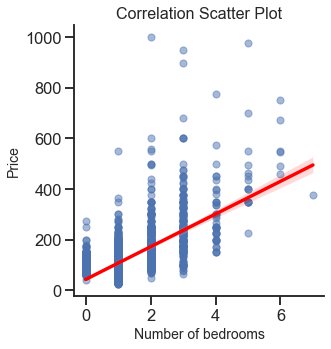

In [54]:
# Set up the seaborn figure
sns.set(style='ticks', color_codes=True)
sns.set_context('talk')

# Create a scatter plot
sns.lmplot(x='bedrooms', y='price', data=df_visualize, scatter_kws={'s':50, 'alpha':0.5}, line_kws={'color': 'red'})

# Set labels and titles
plt.xlabel('Number of bedrooms', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Correlation Scatter Plot', fontsize=16)
plt.show()

As shown by the regression coefficients and the scatter plot, the amount of bedrooms significantly rises de price, so if the aparment has extra space, turning it into a bedroom might be a good idea.
This is in line with the amount of people it can accomodate and if it includes guests.

### Question 2

**2. What are the most desired areas of Seattle, for Airbnb guests?**

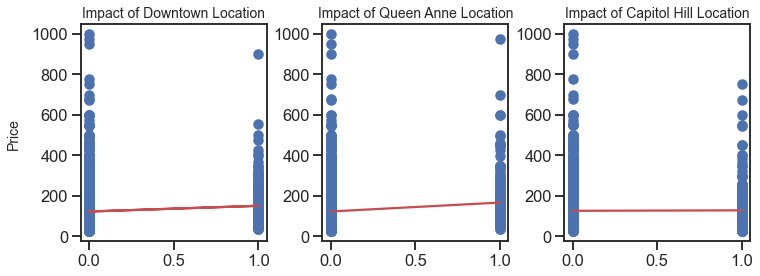

In [77]:
# fit a linear regression model to each dataset
model1 = np.polyfit(df_visualize['neighbourhood_group_cleansed_Downtown'], df_visualize['price'], 1)
model2 = np.polyfit(df_visualize['neighbourhood_group_cleansed_Queen Anne'], df_visualize['price'], 1)
model3 = np.polyfit(df_visualize['neighbourhood_group_cleansed_Capitol Hill'], df_visualize['price'], 1)

# create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# plot the first dataset on the first subplot with trend line
axs[0].scatter(df_visualize['neighbourhood_group_cleansed_Downtown'], df_visualize['price'])
axs[0].plot(df_visualize['neighbourhood_group_cleansed_Downtown'], model1[0]*df_visualize['neighbourhood_group_cleansed_Downtown'] + model1[1], color='r')
axs[0].set_title('Impact of Downtown Location', fontsize=14)

# plot the second dataset on the second subplot with trend line
axs[1].scatter(df_visualize['neighbourhood_group_cleansed_Queen Anne'], df_visualize['price'])
axs[1].plot(df_visualize['neighbourhood_group_cleansed_Queen Anne'], model2[0]*df_visualize['neighbourhood_group_cleansed_Queen Anne'] + model2[1], color='r')
axs[1].set_title('Impact of Queen Anne Location', fontsize=14)

# plot the third dataset on the third subplot with trend line
axs[2].scatter(df_visualize['neighbourhood_group_cleansed_Capitol Hill'], df_visualize['price'])
axs[2].plot(df_visualize['neighbourhood_group_cleansed_Capitol Hill'], model3[0]*df_visualize['neighbourhood_group_cleansed_Capitol Hill'] + model3[1], color='r')
axs[2].set_title('Impact of Capitol Hill Location', fontsize=14)

# set a common y-axis label
fig.text(0.04, 0.5, 'Price', va='center', rotation='vertical', fontsize=14)

# adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3)

# display the plots
plt.show()

According to Table 1, Downtown, Queen Anne and Capitol Hill are the first three locations to show a positive coefficient. This is verified when plotting the correlation between an apartment located in each of these neighbourhoods (x axis equal to 1), and the price. One can see a positive trend (red line) between each pair of variables.

### Question 3

**3. What are some key recommendations for the host?**

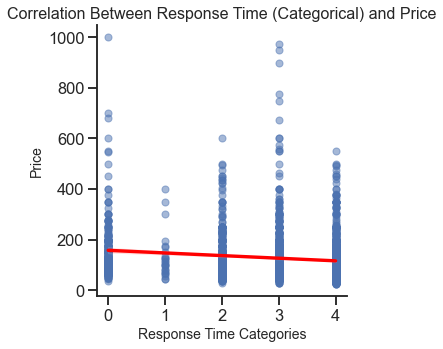

In [81]:
# Set up the seaborn figure
sns.set(style='ticks', color_codes=True)
sns.set_context('talk')

# Create a scatter plot
sns.lmplot(x='host_response_time_num', y='price', data=df_visualize, scatter_kws={'s':50, 'alpha':0.5}, line_kws={'color': 'red'})

# Set labels and titles
plt.xlabel('Response Time Categories', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Correlation Between Response Time (Categorical) and Price', fontsize=16)
plt.show()

Our top 15 variables show one clear advice for the host: speed of response. The data has the 5 following response time categories:
1. Within an hour.
2. Within a few hours.
3. Within a day.
4. A few days or more.
5. (0) None of the above.

The graph shows us how price tends to drop when response time increases.